<a href="https://colab.research.google.com/github/eeroso/Speaker-Verification-using-Siamese-Neural-Network/blob/master/Speaker_Verification_with_Siamese_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Report

### Automatic Speaker Verification Using Siamese Neural Network (ASV)
## **Authors: Eero Sormunen and Alvari Pietarinen**




## Abstract

> In this project we trained a siamese neural network to perform binary classification of two speech utterances to tell if those utterances are from the same speaker. Results were good, over 60% accuracy in all three different scenarios while we kept the training data low. We could get higher accuracies with bigger training dataset.


## Introduction

Describe the research question:

* What is your hypothesis?

  **Detectin if the two speech utterances are from same speaker by using siamese neural network.**

* What are the main issues are you tackling? 

  **Data processing will be the main issue.**

* Break down your approach into steps and describe them. 

  **1. Downloading dataset.**

  **2. Splitting data in training and testing.**

  **3. Splitting data to be accessable to all 3 scenarios.** 

  **4. Taking MFFC for waveforms and adding them to arrays as pairs, also adding corresponding labels whether they are the same speaker or not.** 

  **5. Building, training and testing a siamese neural network.**

  **6. Plotting evaluation metrics**

  **7. Making conclusions**



* Brief description of which dataset you are using.
  
 **AudioMNIST open dataset. There are 60 different speakers and each of them says the digits 0-9 fifty times.**




* How many different ways (approaches) you know that could be used to resolve the hypothesis? 

  **We only know i-vector initially**

* Why did you choose your specific approach?
  **It was given in the instructions and deep learning is an interesting hot topic these days, so gaining experience in that field is good.**

* What are the other methods' merits or drawbacks, and what are the advantages of your method?

  **Siamese neural-network is good when comparing two different occerences of, for example, audio, because input takes two different inputs, not one. Also siamese neural network doesn't require huge amounts of training data. Siamese network can be slower than regular ANNs because of those pairic inputs.**

* What are the goal you achieved in this project?

  **Goal was to get rigour predictions for two speech utterances being from the same speaker. That goal was somewhat achieved.**

# Tasks

## 1. Text Dependent SV
## 2. Text Limited SV
## 3. Text Independent SV


## Used libraries


* _numpy_: for matrix multiplication and array processing
* _matplotlib_: for visualization
* _pyplot_: aswell for visualization
* _sklearn_: for machine learning
* _zipfile_: for extracting dataset
* _os_: for data processing
* _tensorflow_: building neural network
* _random_: to get pseudorandomness in some parts of code
* _sklearn.utils.shuffle_: to shuffle training data
* _librosa_: to process waveforms, get mfcc
* _keras_: for building Siamese ANN, training, evaluating



In [1]:
!pip uninstall scikit-learn
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

'''Run this first, then restart runtime environment and then run all blocks under'''

Uninstalling scikit-learn-0.22.2.post1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scikit_learn-0.22.2.post1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.22.2.post1
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.2MB 48.8MB/s 


'Run this first, then restart runtime environment and then run all blocks under'

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from zipfile import ZipFile 
import os
import tensorflow as tf
import random
from sklearn.utils import shuffle
import librosa 
from keras.models import Model, Sequential
from keras import layers, callbacks, optimizers
import keras.backend as K
import sklearn
sklearn.show_versions()


System:
    python: 3.6.9 (default, Oct  8 2020, 12:12:24)  [GCC 8.4.0]
executable: /usr/bin/python3
   machine: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic

Python dependencies:
          pip: 19.3.1
   setuptools: 50.3.2
      sklearn: 0.24.0rc1
        numpy: 1.18.5
        scipy: 1.4.1
       Cython: 0.29.21
       pandas: 1.1.5
   matplotlib: 3.2.2
       joblib: 0.17.0
threadpoolctl: 2.1.0

Built with OpenMP: True


## Dataset

Here we download and extract the dataset which is used for training and testing our Siamese neural network. Dataset is large containing many kind of speech utterances. We also put all speaker folders to spesific list.

In [3]:
!wget "https://github.com/soerenab/AudioMNIST/archive/master.zip"
filename='master.zip'
with ZipFile(filename, mode='r') as f:
  f.extractall(path='/tmp')

path='/tmp/AudioMNIST-master/data'
os.chdir(path)

speaker_folders = []
for folder in os.listdir(path):
  if os.path.isdir(folder):
    speaker_folders.append(path + '/' + folder + '/')



--2020-12-11 06:22:32--  https://github.com/soerenab/AudioMNIST/archive/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/soerenab/AudioMNIST/zip/master [following]
--2020-12-11 06:22:32--  https://codeload.github.com/soerenab/AudioMNIST/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [                 <=>] 948.50M  9.03MB/s    in 1m 46s  

2020-12-11 06:24:19 (8.93 MB/s) - ‘master.zip’ saved [994575418]



### Split data initially
This function splits data to training and testing data keeping speaker disjoint in mind. Training data contains 48 speakers and testing contains 12. All utterances are aswell split to a dictionary with "Train" or "Test" and chosen digit as their key. -> all_digits["train5"] contains all speech utterances of digit 5 by train speakers. 

In [4]:
def initial_datasplit():
  all_digits={} #Dictionary with digits and their corresponding waveforms
  digits_train=[] #lists to help "appending" to dict
  digits_test=[]
  for i in range(0,10): #all digits 0-9
    for speaker in speaker_folders:
      if float(speaker.split("/")[4]) < 49: #if speaker id 48 or under, goes to train
        for wav in os.listdir(speaker):
          if wav.startswith("{}".format(i)):
            digits_train.append('/tmp/AudioMNIST-master/data/' + wav.split("_")[1] + '/' +  wav)
      if float(speaker.split("/")[4]) > 48:
        for wav in os.listdir(speaker):
          if wav.startswith("{}".format(i)):
            digits_test.append('/tmp/AudioMNIST-master/data/' + wav.split("_")[1] + '/' +  wav)
    all_digits["train{}".format(i)] = digits_train #i means the current digit from the topmost for loop
    digits_train=[]       
    all_digits["test{}".format(i)] = digits_test
    digits_test=[]

  return all_digits



### MFCC
Taking MFCC of given wav and resampling it to 8000hz.

In [5]:
def mfcc(file_path:str, sampling_rate=8000):
  y,sr = librosa.load(file_path, sr = sampling_rate)

  mfccs = librosa.feature.mfcc(y = y, sr = sr)

  return mfccs



### Zero padding, shuffling, validation data splitting and array returning function
After storing MFCCs of all scenarios, we zeropad the shorter MFCCs to same length with the longest one, because you cant feed ANN with varying shapes. This functions also splits the validation set out of training sets, shuffles all datasets and returns the data as np.arrays, which is required for ANNs aswell.

In [6]:
def Zeropad_nparray(X_train_1_t1, X_train_2_t1, y_train_t1, X_test_1_t1, X_test_2_t1, y_test_t1, X_train_1_t2, X_train_2_t2, y_train_t2, X_test_1_t2, X_test_2_t2, y_test_t2, X_train_1_t3, X_train_2_t3,y_train_t3, X_test_1_t3, X_test_2_t3, y_test_t3):
  all=[X_train_1_t1, X_train_2_t1, X_test_1_t1, X_test_2_t1, X_train_1_t2, X_train_2_t2, X_test_1_t2, X_test_2_t2, X_train_1_t3, X_train_2_t3, X_test_1_t3, X_test_2_t3]

  temp = 0
  for array in all:
    for item in array:
      if item.shape[1] > temp:
        temp = item.shape[1]
        


  desired_rows = 20
  desired_cols = temp
  
  for array in all:
    idx=0
    for mfcc in array:
      if mfcc.shape[1] < temp:     
        array[idx] = np.pad(mfcc, ((0, desired_rows-mfcc.shape[0]), (0, desired_cols-mfcc.shape[1])), 'constant', constant_values=0)
      idx = idx+1

  X_train_1_t1, X_train_2_t1, y_train_t1 = shuffle(X_train_1_t1, X_train_2_t1, y_train_t1)

  X_test_1_t1, X_test_2_t1, y_test_t1 = shuffle(X_test_1_t1, X_test_2_t1, y_test_t1)

  X_train_1_t2, X_train_2_t2, y_train_t2 = shuffle(X_train_1_t2, X_train_2_t2, y_train_t2)

  X_test_1_t2, X_test_2_t2, y_test_t2 = shuffle(X_test_1_t2, X_test_2_t2, y_test_t2)

  X_train_1_t3, X_train_2_t3,y_train_t3 = shuffle(X_train_1_t3, X_train_2_t3,y_train_t3)

  X_test_1_t3, X_test_2_t3, y_test_t3 = shuffle(X_test_1_t3, X_test_2_t3, y_test_t3)

  X_val_1_t1, X_val_2_t1, y_val_t1 = X_train_1_t1[1800:], X_train_2_t1[1800:], y_train_t1[1800:]
  X_train_1_t1, X_train_2_t1, y_train_t1 = X_train_1_t1[:1800], X_train_2_t1[:1800], y_train_t1[:1800]
  
  X_val_1_t2, X_val_2_t2, y_val_t2 = X_train_1_t2[2800:], X_train_2_t2[2800:], y_train_t2[2800:]
  X_train_1_t2, X_train_2_t2, y_train_t2 = X_train_1_t2[:2800], X_train_2_t2[:2800], y_train_t2[:2800]
  X_val_1_t3, X_val_2_t3, y_val_t3 = X_train_1_t3[2300:], X_train_2_t3[2300:], y_train_t3[2300:]
  X_train_1_t3, X_train_2_t3, y_train_t3 = X_train_1_t3[:2300], X_train_2_t3[:2300], y_train_t3[:2300]
  


  return np.asarray(X_train_1_t1), np.asarray(X_train_2_t1), np.asarray(y_train_t1), np.asarray(X_test_1_t1), np.asarray(X_test_2_t1), np.asarray(y_test_t1), np.asarray(X_val_1_t1), np.asarray(X_val_2_t1), np.asarray(y_val_t1), np.asarray(X_train_1_t2), np.asarray(X_train_2_t2), np.asarray(y_train_t2), np.asarray(X_test_1_t2), np.asarray(X_test_2_t2), np.asarray(y_test_t2), np.asarray(X_val_1_t2), np.asarray(X_val_2_t2), np.asarray(y_val_t2), np.asarray(X_train_1_t3), np.asarray(X_train_2_t3), np.asarray(y_train_t3), np.asarray(X_test_1_t3), np.asarray(X_test_2_t3), np.asarray(y_test_t3), np.asarray(X_val_1_t3), np.asarray(X_val_2_t3), np.asarray(y_val_t3)
  

### Get Data for Scenario 1 (Text dependent)
This function process the data for scenario number 1. For this purpose we only do the digit 0. It could be any digit. We make sure training data contains at 300 utterances of label 1 (same speaker) and 300 of label 0 (different speakers).
Test set contains 50 of both.

In [7]:
#For Text Dependent training
def Get_Task1_Train_and_Test(all_digits):
  

  Speaker01 = [] 
  Speaker02 = []
  Labels0 = []
  length = len(all_digits["train0"])-1
  tmp = []

  while(len(Labels0) < 2000): 
    if Labels0.count(0) == 1000 and Labels0.count(1) == 1000: 
      break
    else:
      wav1 = all_digits["train0"][random.randint(0, length)]
      wav2 = all_digits["train0"][random.randint(0, length)]
      if [wav1, wav2] not in tmp: 
        if wav1.split("_")[1] == wav2.split("_")[1] and Labels0.count(1) < 1000:
          tmp.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker01.append(mfcc1)
          Speaker02.append(mfcc2)
          Labels0.append(1)
        if wav1.split("_")[1] != wav2.split("_")[1] and Labels0.count(0) < 1000: 
          tmp.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker01.append(mfcc1)
          Speaker02.append(mfcc2)
          Labels0.append(0)




  Speaker01_test = [] 
  Speaker02_test = []
  Labels0_test = []
  length = len(all_digits["test0"])-1
  tmp = []

  while(len(Labels0_test) < 250): 
    if Labels0_test.count(0) == 125 and Labels0_test.count(1) == 125: 
      break
    else:
      wav1 = all_digits["test0"][random.randint(0, length)] 
      wav2 = all_digits["test0"][random.randint(0, length)]
      if [wav1, wav2] not in tmp: 
        if wav1.split("_")[1] == wav2.split("_")[1] and Labels0_test.count(1) < 125: 
          tmp.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker01_test.append(mfcc1)
          Speaker02_test.append(mfcc2)
          Labels0_test.append(1)
        if wav1.split("_")[1] != wav2.split("_")[1] and Labels0_test.count(0) < 125: 
          tmp.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker01_test.append(mfcc1)
          Speaker02_test.append(mfcc2)
          Labels0_test.append(0)



  return Speaker01, Speaker02, Labels0, Speaker01_test, Speaker02_test, Labels0_test


### GET Data for Scenario 2 (Text "limited")
Data processing for scenario 2. In testing every number (0-9) has 100 utterances. 25 of  them are from same speaker (label 1) and rest are from different speaker (label 0). In test set there are 10 utterances from same speaker (label 1) and 10 from different speaker (label 0).

In [8]:
######## TASK 2 ###########

'''Train set:
digits 0-9
Every number occurences 100
of which same speaker 25
'''
def Get_Task2_Train_and_Test(all_digits):
  Speaker09 = [] 
  Speaker09_2 = []
  Labels09 = []
  length = len(all_digits["test0"])-1
  tmp = []
  for dgt in range(0,10):
    counter = 0
    counter1 = 0
    tmp = []
    tmp2 = []
    tmp_dgt = []
    while(counter1<150):
      wav1 = all_digits["train{}".format(dgt)][random.randint(0, length)]
      wav2 = all_digits["train{}".format(random.randint(0,9))][random.randint(0, length)]
      if [wav1, wav2] not in tmp2:
        if wav1.split("_")[1] == wav2.split("_")[1] and tmp_dgt.count(1) < 150:
          tmp2.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker09.append(mfcc1)
          Speaker09_2.append(mfcc2)
          Labels09.append(1)
          tmp_dgt.append(1)
          counter1 = counter1 + 1
    tmp_dgt=[]
    while(counter < 150):
        wav1 = all_digits["train{}".format(dgt)][random.randint(0, length)] 
        wav2 = all_digits["train{}".format(random.randint(0,9))][random.randint(0, length)]
        if [wav1, wav2] not in tmp:
          if wav1.split("_")[1] != wav2.split("_")[1] and tmp_dgt.count(0) < 150:
            tmp.append([wav1, wav2])
            mfcc1 = mfcc(wav1)
            mfcc2 = mfcc(wav2)
            Speaker09.append(mfcc1)
            Speaker09_2.append(mfcc2)
            tmp_dgt.append(0)
            Labels09.append(0)
            counter = counter + 1



  Speaker09_test = [] 
  Speaker09_2_test = []
  Labels09_test = []
  length = len(all_digits["test0"])-1
  tmp = []
  for dgt in range(0,10):
    counter = 0
    counter1 = 0
    tmp = []
    tmp2 = []
    tmp_dgt = []
    while(counter1<10):
      wav1 = all_digits["test{}".format(dgt)][random.randint(0, length)]
      wav2 = all_digits["test{}".format(random.randint(0,9))][random.randint(0, length)]
      if [wav1, wav2] not in tmp2:
        if wav1.split("_")[1] == wav2.split("_")[1] and tmp_dgt.count(1) < 10:
          tmp2.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker09_test.append(mfcc1)
          Speaker09_2_test.append(mfcc2)
          Labels09_test.append(1)
          tmp_dgt.append(1)
          counter1 = counter1 + 1
    tmp_dgt=[]
    while(counter < 10):
        wav1 = all_digits["test{}".format(dgt)][random.randint(0, length)] 
        wav2 = all_digits["test{}".format(random.randint(0,9))][random.randint(0, length)]
        if [wav1, wav2] not in tmp: 
          if wav1.split("_")[1] != wav2.split("_")[1] and tmp_dgt.count(0) < 10:
            tmp.append([wav1, wav2])
            mfcc1 = mfcc(wav1)
            mfcc2 = mfcc(wav2)
            Speaker09_test.append(mfcc1)
            Speaker09_2_test.append(mfcc2)
            tmp_dgt.append(0)
            Labels09_test.append(0)
            counter = counter + 1


  return  Speaker09, Speaker09_2, Labels09, Speaker09_test, Speaker09_2_test, Labels09_test



### GET Data for Scenario 3 (Text independent)
Data processing for scenario 3. In training numbers from 0 to 4. Each number has 200 utterances where 150 are from different speaker (label 0) and 50 from same speaker (label1). In testing numbers from 5 to 9. Same split as in training.


In [9]:
### TASK 3, TEXT INDEPENDENT ###
########TRAIN DATA##################
def Get_Task3_Train_and_Test(all_digits):
  Speaker_04_1 = [] 
  Speaker_04_2 = []
  Labels04 = []
  length = len(all_digits["train0"])-1


  for dgt in range(0,5):
    counter = 0
    counter1 = 0
    tmp = []
    tmp2 = []
    tmp_dgt = []
    while(counter1<250):
      wav1 = all_digits["train{}".format(dgt)][random.randint(0, length)]
      wav2 = all_digits["train{}".format(dgt)][random.randint(0, length)]
      if [wav1, wav2] not in tmp2:
        if wav1.split("_")[1] == wav2.split("_")[1] and tmp_dgt.count(1) < 125:
          tmp2.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker_04_1.append(mfcc1)
          Speaker_04_2.append(mfcc2)
          Labels04.append(1)
          tmp_dgt.append(1)
          counter1 = counter1 + 1
        if wav1.split("_")[1] != wav2.split("_")[1] and tmp_dgt.count(0) < 125:
          tmp2.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker_04_1.append(mfcc1)
          Speaker_04_2.append(mfcc2)
          tmp_dgt.append(0)
          Labels04.append(0)
          counter1 = counter1 + 1
    tmp_dgt=[]
    while(counter < 250):
        wav1 = all_digits["train{}".format(dgt)][random.randint(0, length)] 
        wav2 = all_digits["train{}".format(random.choice([i for i in range(0,5) if i not in [dgt]]))][random.randint(0, length)]
        if [wav1, wav2] not in tmp:
          if wav1.split("_")[1] == wav2.split("_")[1] and tmp_dgt.count(1) < 125:
            tmp.append([wav1, wav2])
            mfcc1 = mfcc(wav1)
            mfcc2 = mfcc(wav2)
            Speaker_04_1.append(mfcc1)
            Speaker_04_2.append(mfcc2)
            Labels04.append(1)
            tmp_dgt.append(1)
            counter = counter + 1
          if wav1.split("_")[1] != wav2.split("_")[1] and tmp_dgt.count(0) < 125:
            tmp.append([wav1, wav2])
            mfcc1 = mfcc(wav1)
            mfcc2 = mfcc(wav2)
            Speaker_04_1.append(mfcc1)
            Speaker_04_2.append(mfcc2)
            tmp_dgt.append(0)
            Labels04.append(0)
            counter = counter + 1
  ##########TRAIN DATA ENDS##############


  ##########TEST DATA#################
  Speaker_59_1 = [] 
  Speaker_59_2 = []
  Labels59 = []
  length = len(all_digits["test5"])-1




  for dgt in range(5,10):
    counter = 0
    counter1 = 0
    tmp = []
    tmp2 = []
    tmp_dgt = []
    while(counter1<50):
      wav1 = all_digits["test{}".format(dgt)][random.randint(0, length)]
      wav2 = all_digits["test{}".format(dgt)][random.randint(0, length)]
      if [wav1, wav2] not in tmp2:
        if wav1.split("_")[1] == wav2.split("_")[1] and tmp_dgt.count(1) < 25:
          tmp2.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker_59_1.append(mfcc1)
          Speaker_59_2.append(mfcc2)
          Labels59.append(1)
          tmp_dgt.append(1)
          counter1 = counter1 + 1
        if wav1.split("_")[1] != wav2.split("_")[1] and tmp_dgt.count(0) < 25:
          tmp2.append([wav1, wav2])
          mfcc1 = mfcc(wav1)
          mfcc2 = mfcc(wav2)
          Speaker_59_1.append(mfcc1)
          Speaker_59_2.append(mfcc2)
          tmp_dgt.append(0)
          Labels59.append(0)
          counter1 = counter1 + 1
    tmp_dgt=[]
    while(counter < 50):
        wav1 = all_digits["test{}".format(dgt)][random.randint(0, length)] 
        wav2 = all_digits["test{}".format(random.choice([i for i in range(5,10) if i not in [dgt]]))][random.randint(0, length)]
        if [wav1, wav2] not in tmp: 
          if wav1.split("_")[1] == wav2.split("_")[1] and tmp_dgt.count(1) < 25: 
            tmp.append([wav1, wav2])
            mfcc1 = mfcc(wav1)
            mfcc2 = mfcc(wav2)
            Speaker_59_1.append(mfcc1)
            Speaker_59_2.append(mfcc2)
            Labels59.append(1)
            tmp_dgt.append(1)
            counter = counter + 1
          if wav1.split("_")[1] != wav2.split("_")[1] and tmp_dgt.count(0) < 25:
            tmp.append([wav1, wav2])
            mfcc1 = mfcc(wav1)
            mfcc2 = mfcc(wav2)
            Speaker_59_1.append(mfcc1)
            Speaker_59_2.append(mfcc2)
            tmp_dgt.append(0)
            Labels59.append(0)
            counter = counter + 1
      




  return Speaker_04_1, Speaker_04_2, Labels04, Speaker_59_1, Speaker_59_2, Labels59



### Data splitting
Calling data splitting functions in each task. Padding them in same shape and returning them as numpy arrays.  Main point of this is getting training and testing set for each task.   

In [10]:
all_digits = initial_datasplit()

#TASK 1 Data
X_train_1_t1, X_train_2_t1, y_train_t1, X_test_1_t1, X_test_2_t1, y_test_t1 = Get_Task1_Train_and_Test(all_digits)


#TASK 2 Data
X_train_1_t2, X_train_2_t2, y_train_t2, X_test_1_t2, X_test_2_t2, y_test_t2 = Get_Task2_Train_and_Test(all_digits)

#TASK 3 Data
X_train_1_t3, X_train_2_t3, y_train_t3, X_test_1_t3, X_test_2_t3, y_test_t3 = Get_Task3_Train_and_Test(all_digits)

#Padding and np_arraying

X_train_1_t1, X_train_2_t1, y_train_t1, X_test_1_t1, X_test_2_t1, y_test_t1, X_val_1_t1, X_val_2_t1, y_val_t1, X_train_1_t2, X_train_2_t2, y_train_t2, X_test_1_t2, X_test_2_t2, y_test_t2, X_val_1_t2, X_val_2_t2, y_val_t2, X_train_1_t3, X_train_2_t3, y_train_t3, X_test_1_t3, X_test_2_t3, y_test_t3, X_val_1_t3, X_val_2_t3, y_val_t3 = Zeropad_nparray(X_train_1_t1, X_train_2_t1, y_train_t1, X_test_1_t1, X_test_2_t1, y_test_t1, X_train_1_t2, X_train_2_t2, y_train_t2, X_test_1_t2, X_test_2_t2, y_test_t2, X_train_1_t3, X_train_2_t3,y_train_t3, X_test_1_t3, X_test_2_t3, y_test_t3)



### Histogram of train and test data




/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test data')

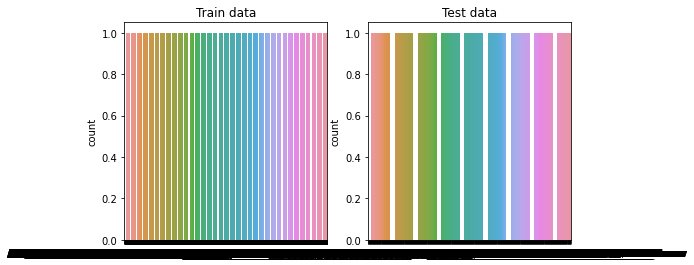

In [ ]:

plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
sns.countplot(all_digits["train5"], ax=ax)
ax.set_title('Train data')
ax = plt.subplot(1, 2, 2)
sns.countplot(all_digits["test6"], ax=ax)
ax.set_title('Test data')


## Model description

Which algorithm you used for solving the task?

*** Siamese neural network ***

Write down technical description of the algorithm (maths and steps).

* How to initialize the model?
 
 Calling function with input_shape which is the shape of one MFCC feature. After that we initialize one dimensional CNN-layer which takes one MFCC spectrogram as parameter. We add second layer to get possible more accurate results. These two CNNs are the encoder. With this encoder we encode input MFCCs so we can calculate their similarity in substraction layer. Then we create output layer which is sigmoid activation of this embedded distance. Finally we build siamise network which input layer is the encoder and output layer is sigmoided layer. 
 

* Which parameters are important and relevant for our dataset?

  Optimizer and learning rate, activation, loss function and the amount of nodes in layers. 

* How we fit the model?

  We give it paired list of training MFCCs and their corresponding labels (which is 0 when different speaker and 1 when same speaker). Then we set epoch and batch size. We also use early stopping callback to stop epochs if loss is starting to increase. 

* How do we perform prediction and evaluation with the model?

  Prediction is made by giving the trained model pairs of MFCCs which we want to predict. It return score between 0 and 1 which is probability of being same speaker. Then we have some threshold which we compare the score to and if the score exceeds the threshold it is same speaker. Evaluation is made by giving the trained model pairs of mffcs and their corresponding true labels. It then predicts each pair and checks if it was correct. It returns the accuracy of all predictions.



<img src="https://images-ext-1.discordapp.net/external/GDsdUXM5qzlWdyYW1s7yzsXWBBIAmscj4qtT1NpPlWo/https/i.gyazo.com/thumb/1200/65ae1a75653100d4c4c574ba5c6d312c-png.jpg" size="500"/>

### Initializing siamise neural network

In [11]:
def siamese(input_shape):

    encoder = Sequential()

    encoder.add(layers.Conv1D(128, 9, padding='same', activation='relu', input_shape=input_shape))
    encoder.add(layers.Conv1D(64, 7, activation='relu', padding='same'))
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)

    encoded_1 = encoder(input_1)
    encoded_2 = encoder(input_2)

    # This is the distance metric used in the original one-shot paper
    embedded_distance = layers.Subtract()([encoded_1, encoded_2]) 
    embedded_distance = layers.Lambda(lambda x: K.abs(x))(embedded_distance)
    output = layers.Dense(1, activation='sigmoid')(embedded_distance)

    siamese = Model(inputs=[input_1, input_2], outputs=output)
    siamese.summary()
    return siamese




### Testing for Scenario 1

In [12]:
#TASK 1
siam = siamese(X_train_1_t1[1].shape)
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)
opt = optimizers.Adam(learning_rate=0.002)
siam.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

siam.fit(x=[X_train_1_t1, X_train_2_t1], y=y_train_t1, validation_data=([X_val_1_t1, X_val_2_t1], y_val_t1), epochs=38, batch_size=50, callbacks=[callback])

scores = siam.evaluate([X_test_1_t1, X_test_2_t1], y_test_t1)



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 20, 64)       75968       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 20, 64)       0           sequential[0][0]      

### Testing for Scenario 2

In [13]:
#TASK 2 Tests
siam2 = siamese(X_train_1_t2[1].shape)

opt = optimizers.Adam(learning_rate=0.002)

callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)

siam2.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

siam2.fit(x=[X_train_1_t2, X_train_2_t2], y=y_train_t2, epochs=20, validation_data=([X_val_1_t2, X_val_2_t2], y_val_t2), batch_size=64, callbacks=[callback])

scores = siam2.evaluate([X_test_1_t2, X_test_2_t2], y_test_t2)

print("Accuracy: ", scores[1])



Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 20, 64)       75968       input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 20, 64)       0           sequential_1[0][0]    

### Testing for Scenario 3

In [14]:
#TASK 3 

siam3 = siamese(X_train_1_t3[1].shape)
opt = optimizers.Adam(learning_rate=0.002)
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)
siam3.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

siam3.fit(x=[X_train_1_t3, X_train_2_t3], y=y_train_t3, validation_data=([X_val_1_t3, X_val_2_t3], y_val_t3), epochs=20, batch_size=64, callbacks=[callback])

scores = siam3.evaluate([X_test_1_t3, X_test_2_t3], y_test_t3)
preds = siam3.predict([X_test_1_t3, X_test_2_t3])
print("Accuracy: ", scores[1])


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 20, 64)       75968       input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 20, 64)       0           sequential_2[0][0]    

# Experiments and results

Describe your experiments setup

* which metrics are used for evaluation?

  Det-Curve

* How do you run the experiments?

   We calculate the false positive rates and false negative rates and plot them as DET

  



###  Getting test data

Code where we get the actual Test data. Our initial test data contains way more data than was supposed to be for testing.

In [15]:
from sklearn.metrics import det_curve
#Task1
idx_list_same=[]
idx_list_dif=[]
for idx in range(len(y_test_t1)-1):
  if y_test_t1[idx] == 1:
    idx_list_same.append(idx)
  else:
    idx_list_dif.append(idx)
Test_task1_X = []
Test_task1_X2 = []
Test_task1_Y = []
for i in range(10):
  Test_task1_X.append(X_test_1_t1[idx_list_same[i]])
  Test_task1_X2.append(X_test_2_t1[idx_list_same[i]])
  Test_task1_Y.append(y_test_t1[idx_list_same[i]])
for j in range(50):
  Test_task1_X.append(X_test_1_t1[idx_list_dif[j]])
  Test_task1_X2.append(X_test_2_t1[idx_list_dif[j]])
  Test_task1_Y.append(y_test_t1[idx_list_dif[j]])
preds = siam.predict([np.array(Test_task1_X), np.array(Test_task1_X2)])
predictions=[]
for pred in preds:
  predictions.append(np.mean(pred))

#Task2
idx_list_same=[]
idx_list_dif=[]
for idx in range(len(y_test_t2)-1):
  if y_test_t2[idx] == 1:
    idx_list_same.append(idx)
  else:
    idx_list_dif.append(idx)
Test_task2_X = []
Test_task2_X2 = []
Test_task2_Y = []
for i in range(10):
  Test_task2_X.append(X_test_1_t2[idx_list_same[i]])
  Test_task2_X2.append(X_test_2_t2[idx_list_same[i]])
  Test_task2_Y.append(y_test_t2[idx_list_same[i]])
for j in range(50):
  Test_task2_X.append(X_test_1_t2[idx_list_dif[j]])
  Test_task2_X2.append(X_test_2_t2[idx_list_dif[j]])
  Test_task2_Y.append(y_test_t2[idx_list_dif[j]])

preds = siam2.predict([np.array(Test_task2_X), np.array(Test_task2_X2)])
predictions2=[]
for pred in preds:
  predictions2.append(np.mean(pred))


#Task3
idx_list_same=[]
idx_list_dif=[]
for idx in range(len(y_test_t3)-1):
  if y_test_t3[idx] == 1:
    idx_list_same.append(idx)
  else:
    idx_list_dif.append(idx)
Test_task3_X = []
Test_task3_X2 = []
Test_task3_Y = []
for i in range(10):
  Test_task3_X.append(X_test_1_t3[idx_list_same[i]])
  Test_task3_X2.append(X_test_2_t3[idx_list_same[i]])
  Test_task3_Y.append(y_test_t3[idx_list_same[i]])
for j in range(50):
  Test_task3_X.append(X_test_1_t3[idx_list_dif[j]])
  Test_task3_X2.append(X_test_2_t3[idx_list_dif[j]])
  Test_task3_Y.append(y_test_t3[idx_list_dif[j]])


preds = siam3.predict([np.array(Test_task3_X), np.array(Test_task3_X2)])


predictions3=[]
for pred in preds:
  predictions3.append(np.mean(pred))




## Results and diccussion

**When false negative rate decreases false positive rate increases in our model's predictions. In first task we have 'the best' DET-curve, which is related to its overall superior accuracy. In the 2nd and 3rd task our scores are not so good. We have either pretty high FPR or FNR. This means that our model makes wrong predictions, by classifying same speakers as different or different speakers as the same.**

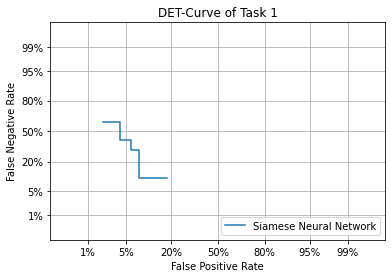

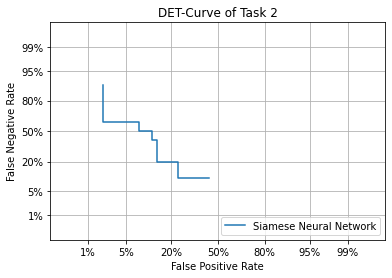

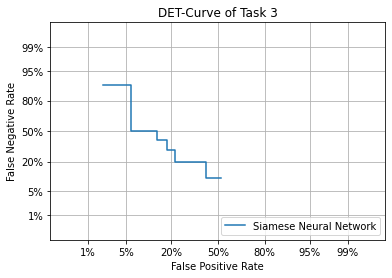

In [16]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fpr_t1, fnr_t1, thresholds_t1 = det_curve(Test_task1_Y, predictions)

fpr_t2, fnr_t2, thresholds_t2 = det_curve(Test_task2_Y, predictions2)

fpr_t3, fnr_t3, thresholds_t3 = det_curve(Test_task3_Y, predictions3)

display = metrics.DetCurveDisplay(fpr=fpr_t1, fnr=fnr_t1, estimator_name='Siamese Neural Network')

display2 = metrics.DetCurveDisplay(fpr=fpr_t2, fnr=fnr_t2, estimator_name='Siamese Neural Network')

display3 = metrics.DetCurveDisplay(fpr=fpr_t3, fnr=fnr_t3, estimator_name='Siamese Neural Network')

display.plot() 
plt.title("DET-Curve of Task 1")
plt.grid()
display2.plot() 
plt.title("DET-Curve of Task 2")
plt.grid()
display3.plot() 
plt.title("DET-Curve of Task 3")
plt.grid()

plt.show()



## Conclusion
In conclusion, our siamese model is making decent predictions and performing overall good. We could get much better performance by using larger training sets and performing more professional hyperparameter tuning. These current hyperparameters are based on our small tests, so they propably are not the exact optimal ones. Also we are not sure about data distribution. For example we manually take same amount of same and different speakers, but it has much more questions. Now we use randomization but randomization means that its possible of ending up with large amounts of specific numbers and small amount of other specific numbers since we only track speakers. 